In [67]:
import string, re, json, pickle, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
# importing the wordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bidi.algorithm import get_display
import arabic_reshaper
from data_preparation import take_a_shower, clean_content_aravec

%matplotlib inline
warnings.filterwarnings('ignore')

## Import data

In [2]:
data = pd.read_csv('./data/offensive_dataset.csv', encoding="utf-16")
data.head()

,Comment,is_off
0,شوف حد ين*** أنت و إيران.,1
1,شوف تيفي قوداتها مع الجن غي بلاتي يجي من مكة,0
2,عجب يتفاوظون على شعوب عربية وعليهم وهىلا تعلم,0
3,ههههههه هاد شوف تيفي اللي حطت عليه مشا فيها,0
4,الرزق يأتي من حيث لا تدري 🙌🏻❤️,0


<Figure size 576x432 with 0 Axes>

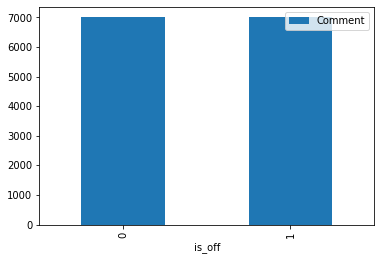

In [22]:
fig = plt.figure(figsize=(8,6))
data.groupby('is_off').count().plot.bar(ylim=0)
plt.show()

## Clean data

In [3]:
data.Comment = data.Comment.apply(take_a_shower)

In [4]:
data.shape

(14000, 2)

## Word Cloud

In [5]:
comments = ' '.join(list(data.Comment))
comments[0:1000]

'شوف حد ايران شوف تيفي قوداتها الجن غي بلاتي يجي مكه عجب يتفاوظون شعوب عربيه وعليهم وهيلا تعلم هه هاد شوف تيفي اللي حطت مشا الرزق ياتي تدري 🙌🏻❤️ دخلو سوق كركم شوفو شكون مكتب عليكم تعيشو عبيد فقراء معا USERIDX لسسه امبارح بحذركو ولاد الجزمه فيفي ولاد شرموطه هه😂 Hadou jouj zeal hachak machi drari الله يعفو مسكينه دغيا طارو سصحاب الحسنات باش يستغلوها حرام عليهو الله يخد الحق شوف تفي عواد متسترها شهراتها لناس تفو شحاال حامضه هاد سعييده معرفت علاه كيجيبوها فين ميكون هاد لموسم ديال طنطان يجيبوها لينا يالطيف حد مكيحملها الطلب السعودي جاء ردا الاتهامات الاسراءيليه للسعوديه بقتل الاطفال باليمن اسوه بقتل اسراءيل للاطفال الفلسطينيين جاء تقرير المتحده بلاش فقره الاهداءات وادا لابد خليها نهايه الفيديو احسن وبالتوفيق ياعمر يااربي يااربي تلطف بينا نجم كندا هه روبيني الخرا هه اللهم اشغلهم بانفسهم واجعل كيدهم نحرهم واجعل تدبيرهم تدميرهم ودمرهم تدميرا ومزقهم شر ممزق قوي متين الله ماشي سيمحمد خصها تسميك سوسو المتوحشه 🤣🤣 Tomas Shelby mzhiha 😂 اين تعليقي ياجزيره اعتقد المنطق الكلام توجد اساء وانما تعقيب كل

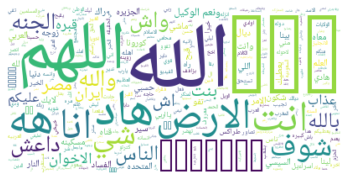

In [6]:
# handling arabic text
comments = arabic_reshaper.reshape(comments[0:10000])
comments = get_display(comments)

wordcloud = WordCloud(font_path='assets/NotoNaskhArabic-Regular.ttf',
                      background_color="white",
                      max_words=1000,
                      mode='RGBA').generate(comments)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## splitting the data into target and feature

In [59]:
feature = data.Comment
target = data.is_off
# splitting into train and tests
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size =.2, random_state=100)

In [44]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
print(X_train_counts.shape)

(11200, 47531)


In [45]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11200, 47531)

## Logistic Regression Model

In [46]:
lr_clf = LogisticRegression(C=1).fit(X_train_tfidf, Y_train)
# make prediction and print accuracy
lr_prediction = lr_clf.predict(count_vect.transform(X_test))
print(f"Accuracy score is {accuracy_score(Y_test, lr_prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.77
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1406
           1       0.79      0.78      0.79      1394

    accuracy                           0.79      2800
   macro avg       0.79      0.79      0.79      2800
weighted avg       0.79      0.79      0.79      2800



In [51]:
lr_clf.predict(count_vect.transform([take_a_shower('الزمر فالطوندونس هو باطمة تلاقيتو تواتيتو')]))

array([1])

In [48]:
# make pipeline
pipe = make_pipeline(CountVectorizer(),
                     TfidfTransformer(),
                     LogisticRegression())
# make param grid
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

# create and fit the model
model = GridSearchCV(pipe, param_grid, cv=5, verbose=10)
model.fit(X_train,Y_train)

# make prediction and print accuracy
prediction = model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.79
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1406
           1       0.79      0.78      0.79      1394

    accuracy                           0.79      2800
   macro avg       0.79      0.79      0.79      2800
weighted avg       0.79      0.79      0.79      2800



In [34]:
model.best_params_

{'logisticregression__C': 1}

In [54]:
model.predict([take_a_shower('الزمر فالطوندونس هو باطمة تلاقيتو تواتيتو')])

array([1])

In [56]:
pickle.dump(model, open('./models/count_vect/lr_model.model', 'wb'))

## SVM Model

In [70]:
pipe = make_pipeline(CountVectorizer(),
                     TfidfTransformer(),
                     SVC())
param_grid = {'svc__kernel': ['rbf', 'linear', 'poly'],
             'svc__gamma': [0.1, 1, 10, 100],
             'svc__C': [0.1, 1, 10, 100]}

svc_model = GridSearchCV(pipe, param_grid, cv=5, verbose=10)
svc_model.fit(X_train, Y_train)

prediction = svc_model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, score=0.539, total=  10.5s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, score=0.533, total=  10.9s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, score=0.547, total=  12.8s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf .....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.2s remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, score=0.549, total=  14.3s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf .....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   48.5s remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, score=0.553, total=  12.2s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=linear ..................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=linear, score=0.719, total=   9.2s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=linear ..................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=linear, score=0.725, total=   9.0s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=linear ..................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=linear, score=0.729, total=   9.0s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=linear ..................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=linear, score=0.723, total=   9.0s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=linear ..................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=linear, score=0.718, total=   9.0s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=poly ....................
[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=poly, score=0.500, total=   9.2s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=poly ....................
[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=poly, score=0.500, total=   9.1s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=poly ....................
[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=poly, score=0.500, total=   9.1s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=poly ....................
[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=poly, score=0.500, total=   9.3s
[CV] svc__C=0.1, svc__gamma=0.1, svc__kernel=poly ....................
[CV]  svc__C=0.1, svc__gamma=0.1, svc__kernel=poly, score=0.501, total=   9.1s
[CV] svc__C=0.1, svc__gamma=1, svc__kernel=rbf .......................
[CV]  svc__C=0.1, svc__gamma=1, svc__kernel=rbf, score=0.568, total=  10.2s
[CV] svc__C=0.1, svc__

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 106.6min finished


Accuracy score is 0.79
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1406
           1       0.79      0.79      0.79      1394

    accuracy                           0.79      2800
   macro avg       0.79      0.79      0.79      2800
weighted avg       0.79      0.79      0.79      2800



In [71]:
svc_model.best_params_

{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}

In [72]:
svc_model.predict([take_a_shower('الزمر فالطوندونس هو باطمة تلاقيتو تواتيتو')])

array([1])

In [73]:
pickle.dump(svc_model, open('./models/count_vect/svm_model.model', 'wb'))

## Random Forest Model

In [62]:
pipe = make_pipeline(CountVectorizer(),
                     TfidfTransformer(),
                    RandomForestClassifier())

param_grid = {'randomforestclassifier__n_estimators':[10, 100, 1000],
             'randomforestclassifier__max_features':['sqrt', 'log2']}

rf_model = GridSearchCV(pipe, param_grid, cv=5)
rf_model.fit(X_train,Y_train)

prediction = rf_model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.81
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1406
           1       0.85      0.75      0.80      1394

    accuracy                           0.81      2800
   macro avg       0.82      0.81      0.81      2800
weighted avg       0.82      0.81      0.81      2800



In [64]:
rf_model.best_params_

{'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__n_estimators': 100}

In [65]:
rf_model.predict([take_a_shower('الزمر فالطوندونس هو باطمة تلاقيتو تواتيتو')])

array([1])

In [66]:
pickle.dump(rf_model, open('./models/count_vect/randomforest_model.model', 'wb'))